In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import os
import gene as bgene
import shuffle
from scipy.stats import pearsonr

2023-12-26 08:07:23.757459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


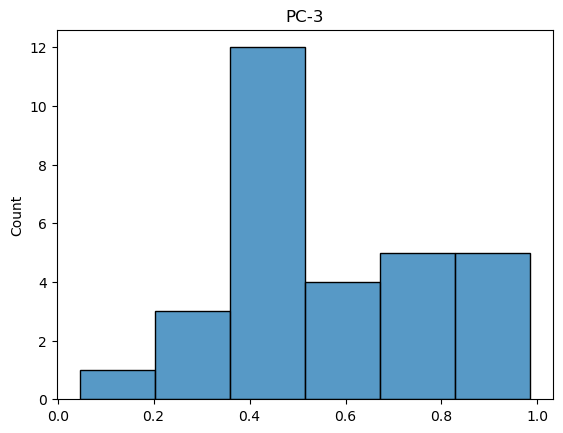

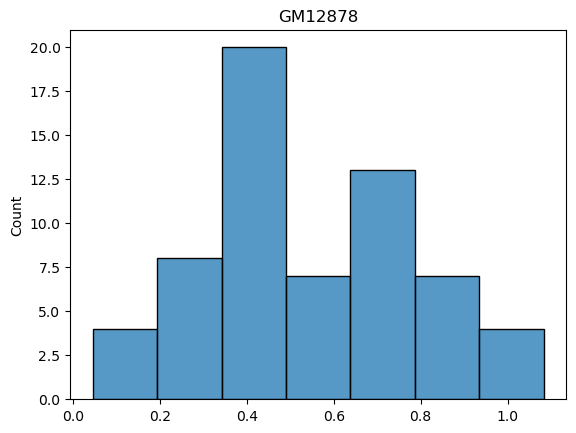

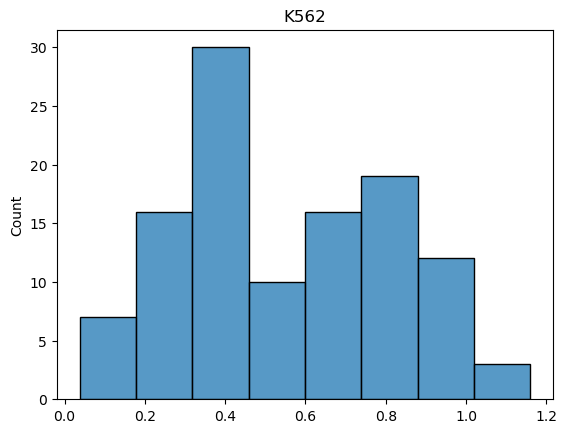

In [28]:
best_tiles = []
bad_counter = 0
for cell in ['PC-3', 'GM12878', 'K562']:
    for f in glob.glob(f'../results/motifs_1000/{cell}/*'):
        res = utils.read_pickle(f)
        if 1000 in res.keys():
            best_tiles.append(np.max(res[1000].mean(axis=0) / res['pred_mut']))
        else:
            bad_counter += 1
    sns.histplot(best_tiles)
    plt.title(cell)
    plt.show()

In [2]:

track_index = [5111]
bin_index = [447, 448]
data_dir = '../data/'
model = custom_model.Enformer(track_index=track_index, bin_index=bin_index)
target_df = pd.read_csv(f'{data_dir}/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]

cell_channel = np.argwhere(np.array(cell_lines) == 'K562').flatten()[0]
model_name = 'enformer'

shuffle_num = 10

seq_parser = utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')

cre_df = pd.read_csv(f'../results/sufficiency_test/{model_name}_selected_cres.csv')
cre_df = cre_df[cre_df['tile class']=='Enhancer']
cre_df = cre_df[cre_df['cell_line']=='K562']

tile_coords = pd.read_csv(f'../results/sufficiency_test/{model_name}/tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

tile_size = cre_tile_coords[0][1] - cre_tile_coords[0][0]
# cre_df = cre_df.sample(frac=1)

tile_effects = {}


2023-12-23 13:21:24.325262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 13:21:24.656869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77431 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [18]:
%%time
per_seq_results = []

minitile_size = 100
threshold = 0.7 
N_batch = 5
_, row = next(cre_df.iterrows())

chrom, tss_site, strand = row['seq_id'].split('_')[1:]
wt_seq = seq_parser.extract_seq_centered(chrom, int(tss_site), strand, model.seq_length) # get seq

pred_wt, pred_mut, pred_control, control_sequences = creme.sufficiency_test(model, wt_seq, tss_tile,
                                                             [[row['tile_start'], row['tile_end']]],
                                                             shuffle_num, mean=False, return_seqs=True)
wt = pred_wt.mean()
mut = pred_mut.mean()
control = pred_control.mean()
if (mut - control) / wt > 0.3:
    
    minitile_starts = list(range(row['tile_start'], row['tile_end'] - minitile_size + 1, minitile_size//2))
    number_of_tiles = len(minitile_starts)
    score = 1 # start with no minitile removed
    removed_tiles = np.array([]) # none selected at start
    new_selected_tiles = []
    remaining_to_test = minitile_starts.copy() # start with full list of minitile starts
    pruned_seqs = control_sequences.copy() # 10 shuffled versions with just TSS
    pruned_seqs[:, row['tile_start']:row['tile_end'], :] = (wt_seq[row['tile_start']:row['tile_end']]).copy() # start with intact CRE
    while score > threshold: 
        print(score)
        results = [] # [len = number of remaining tiles to test]

        # remove one minitile at a time
        for j, minitile_start in tqdm(enumerate(remaining_to_test), total=len(remaining_to_test)):
            minitile_end = minitile_start+minitile_size
            # "remove" minitile by putting back shuffled version 
            seq_extra_minitile_shuffled = pruned_seqs.copy()
            # use the control sequence to shuffle minitile
            seq_extra_minitile_shuffled[:, minitile_start: minitile_end, :] = control_sequences[:, minitile_start: minitile_end, :].copy()
            results.append(model.predict(seq_extra_minitile_shuffled).mean())

        new_selected_tiles = np.array(remaining_to_test)[np.argsort(results)[-N_batch:]] # choose N useless
        removed_tiles = np.concatenate([removed_tiles, new_selected_tiles]) # add to santa's bad list

        # prune the list and sequences to test based on this iteration
        for removed_tile in new_selected_tiles:
            remaining_to_test.remove(removed_tile) 
            pruned_seqs[:, removed_tile:removed_tile+minitile_size, :] = (control_sequences[:, removed_tile:removed_tile+minitile_size, :]).copy()

        # compute new score
        score = model.predict(pruned_seqs).mean() / mut
        per_seq_results.append(score)

        

1


100%|██████████████████████████████████████████████████████████████████| 99/99 [04:47<00:00,  2.91s/it]


1.2819945


100%|██████████████████████████████████████████████████████████████████| 94/94 [04:33<00:00,  2.91s/it]


1.5593028


100%|██████████████████████████████████████████████████████████████████| 89/89 [04:20<00:00,  2.93s/it]


1.7389371


100%|██████████████████████████████████████████████████████████████████| 84/84 [04:06<00:00,  2.94s/it]


1.8065709


100%|██████████████████████████████████████████████████████████████████| 79/79 [03:52<00:00,  2.94s/it]


1.8309152


100%|██████████████████████████████████████████████████████████████████| 74/74 [03:37<00:00,  2.94s/it]


1.851173


100%|██████████████████████████████████████████████████████████████████| 69/69 [03:22<00:00,  2.94s/it]


1.8467243


100%|██████████████████████████████████████████████████████████████████| 64/64 [03:08<00:00,  2.94s/it]


1.8117392


100%|██████████████████████████████████████████████████████████████████| 59/59 [02:53<00:00,  2.94s/it]


1.7843958


100%|██████████████████████████████████████████████████████████████████| 54/54 [02:38<00:00,  2.94s/it]


1.6992961


100%|██████████████████████████████████████████████████████████████████| 49/49 [02:26<00:00,  3.00s/it]


1.6268435


100%|██████████████████████████████████████████████████████████████████| 44/44 [02:09<00:00,  2.94s/it]


1.5675118


100%|██████████████████████████████████████████████████████████████████| 39/39 [01:59<00:00,  3.05s/it]


1.4889007


100%|██████████████████████████████████████████████████████████████████| 34/34 [01:39<00:00,  2.93s/it]


1.3870434


100%|██████████████████████████████████████████████████████████████████| 29/29 [01:25<00:00,  2.96s/it]


1.2743208


100%|██████████████████████████████████████████████████████████████████| 24/24 [01:10<00:00,  2.94s/it]


1.1630526


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.94s/it]


0.80935967


100%|██████████████████████████████████████████████████████████████████| 14/14 [00:41<00:00,  2.98s/it]


0.80820906


100%|████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.94s/it]


CPU times: user 2min 8s, sys: 2min 37s, total: 4min 45s
Wall time: 51min 20s


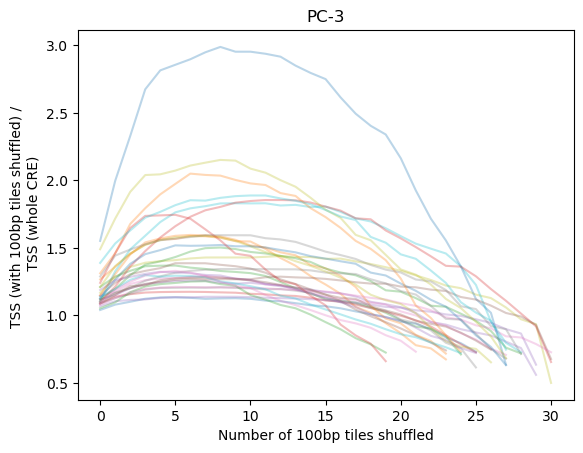

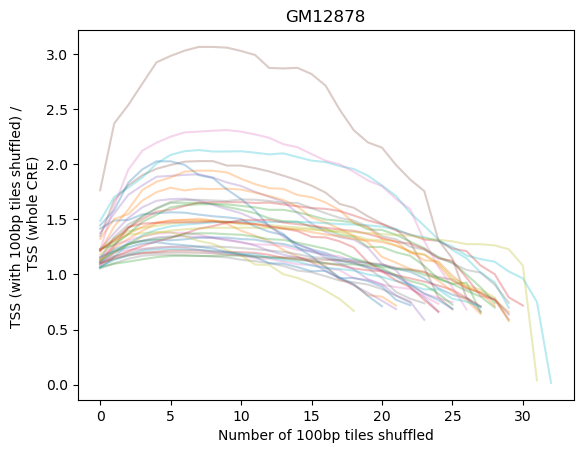

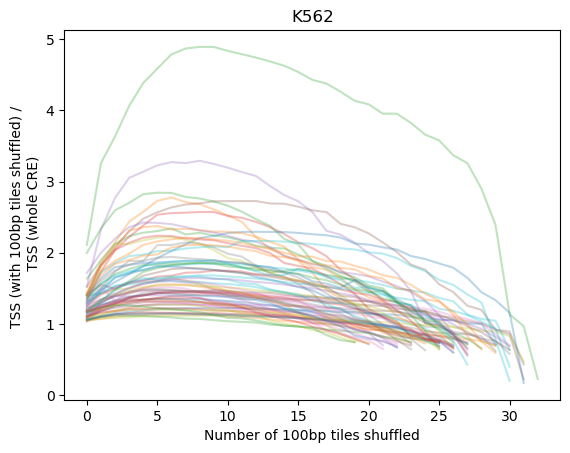

In [19]:
result_dir = '../results/motifs_100_batch_3_shuffle_10_thresh_0.75'
for cell in os.listdir(result_dir):
    for res_path in glob.glob(f'{result_dir}/{cell}/*pickle'):
        per_seq_results = utils.read_pickle(res_path)
        if 'fraction_explained' in per_seq_results.keys():
            frac_explained = per_seq_results['fraction_explained']
            plt.plot(frac_explained, alpha=0.3)

    plt.title(cell)
    plt.xlabel('Number of 100bp tiles shuffled')
    plt.ylabel('TSS (with 100bp tiles shuffled) / \n TSS (whole CRE)')
    plt.show()
        

In [10]:
res_path

'../results/motifs_100_batch_3_shuffle_10_thresh_0.75/PC-3/CARD6_chr5_40841307_+_90804_95804.pickle'

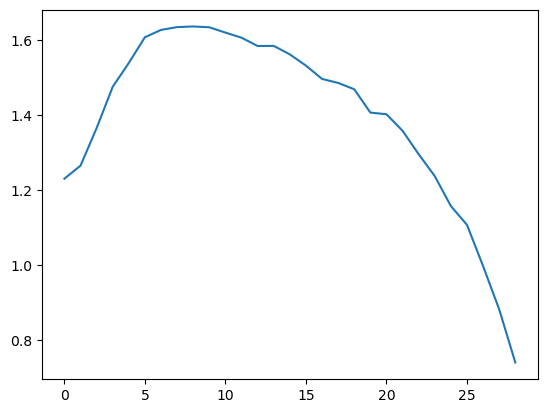